In [162]:
import pandas as pd
import numpy as np
from keras.models import Sequential , load_model
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D,Reshape
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import BorderlineSMOTE

In [163]:
#读取数据
X_train = pd.read_csv('../preprocessed_data/X_train.csv',header=None).values
X_test = pd.read_csv('../preprocessed_data/X_test.csv',header=None).values

In [164]:
y_train = pd.read_csv('../preprocessed_data/y_train.csv',header=None)
y_test = pd.read_csv('../preprocessed_data/y_test.csv',header=None)

In [165]:
DoS = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
Probe = ['ipsweep','mscan','nmap','portsweep','saint','satan']
R2L = ['ftp_write','guess_passwd','httptunnel','imap','multihop','phf','sendmail','snmpgetattack','spy','snmpguess','warezclient','warezmaster','xlock','xsnoop','named']
U2R = ['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm']

In [166]:
#将y_train和y_test中的异常子类映射为四大类
y_train = y_train.replace(DoS,'DoS')
y_train = y_train.replace(Probe,'Probe')
y_train = y_train.replace(R2L,'R2L')
y_train = y_train.replace(U2R,'U2R')

y_test = y_test.replace(DoS,'DoS')
y_test = y_test.replace(Probe,'Probe')
y_test = y_test.replace(R2L,'R2L')
y_test = y_test.replace(U2R,'U2R')

In [167]:
#查看各类别样本数量
print(y_train[0].value_counts())
print(y_test[0].value_counts())
#确保每个异常子类都被映射为四大类

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: 0, dtype: int64
normal    9711
DoS       7460
R2L       2885
Probe     2421
U2R         67
Name: 0, dtype: int64


In [168]:
#对训练集进行随机复制过采样
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)

In [169]:
#对训练集进行BorderlineSMOTE随机过采样(2'40")
#borderline_smote = BorderlineSMOTE(random_state=42)
#X_train, y_train = borderline_smote.fit_resample(X_train, y_train)
#试过了,效果不好

In [170]:
#查看各类别样本数量
print(y_train[0].value_counts())

normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: 0, dtype: int64


In [171]:
#对y_train和y_test使用sklearn的to_categorical函数进行one-hot编码
from sklearn.preprocessing import OneHotEncoder
#合并y_train和y_test
y = np.concatenate((y_train,y_test))
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1)).toarray()
y_train = y[:len(y_train)]
y_test = y[len(y_train):]

In [172]:
#划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [173]:
#构建模型
CNNmodel = Sequential([
    Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    Conv1D(32, 64, padding='same', input_shape=(X_train.shape[1],1), activation='tanh'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, 32, padding='same', activation='tanh'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, 16, padding='same', activation='tanh'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(512, activation='tanh'),
    Dropout(0.2),
    Dense(256, activation='tanh'),
    Dropout(0.1),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(y_train.shape[1], activation='softmax'),
],name='CNNmodel')
#编译模型
CNNmodel.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
CNNmodel.summary()

Model: "CNNmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 123, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 123, 32)           2080      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 61, 32)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 61, 64)            65600     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 30, 64)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 30, 128)           131200    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 15, 128)           0  

In [174]:
def plotHistory(history):
    # 找到最好的 val_accuracy 和对应的迭代数
    best_val_acc = max(history.history['val_accuracy'])
    best_val_acc_epoch = history.history['val_accuracy'].index(best_val_acc)
    total_epochs = len(history.history['val_accuracy'])
    # 绘制图形
    plt.figure(figsize=(15, 8))
    plt.plot(history.history['val_accuracy'],c = 'g')
    # 添加趋势线
    z1 = np.polyfit(range(0,total_epochs), history.history['val_accuracy'], 4)
    p1 = np.poly1d(z1)
    plt.plot(range(0,total_epochs),p1(range(0,total_epochs)),"r--")
    # 标出最好的 val_accuracy 和对应的迭代数,并注上文字
    plt.scatter(best_val_acc_epoch, best_val_acc, c='b', marker='*', s=100)
    plt.text(best_val_acc_epoch, best_val_acc,f'({best_val_acc:.3f},{best_val_acc_epoch})', ha='center', va='bottom', fontsize=8)
    #plt.title('CNNmodel val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['validation_acc', 'acc_trend'], loc='upper left')
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['right'].set_color('none')
    plt.show()

Train on 100778 samples, validate on 25195 samples
Epoch 1/15
100778/100778 [==============================] - 4s 37us/step - loss: 0.1948 - accuracy: 0.9394 - val_loss: 0.0262 - val_accuracy: 0.9915
Epoch 2/15
100778/100778 [==============================] - 3s 33us/step - loss: 0.0180 - accuracy: 0.9953 - val_loss: 0.0209 - val_accuracy: 0.9945
Epoch 3/15
100778/100778 [==============================] - 3s 33us/step - loss: 0.0127 - accuracy: 0.9961 - val_loss: 0.0170 - val_accuracy: 0.9950
Epoch 4/15
100778/100778 [==============================] - 3s 33us/step - loss: 0.0093 - accuracy: 0.9971 - val_loss: 0.0140 - val_accuracy: 0.9955
Epoch 5/15
100778/100778 [==============================] - 3s 33us/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.0109 - val_accuracy: 0.9973
Epoch 6/15
100778/100778 [==============================] - 3s 33us/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0130 - val_accuracy: 0.9963
Epoch 7/15
100778/100778 [=============================

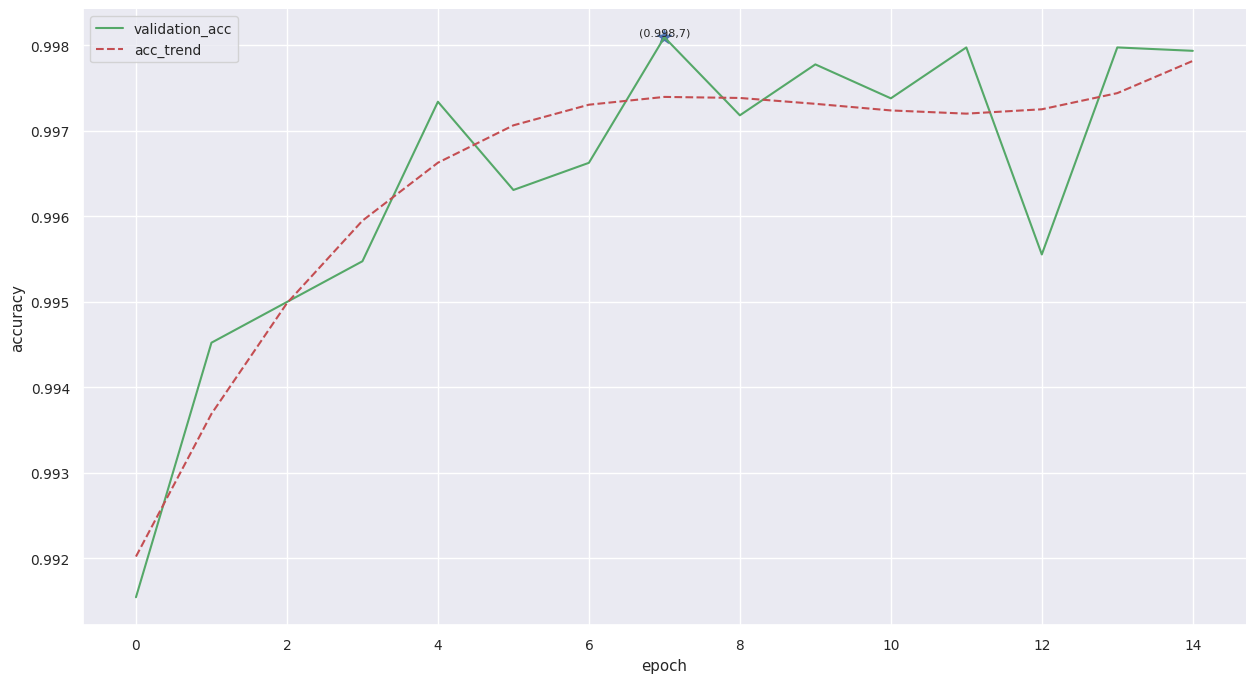

In [175]:
history = CNNmodel.fit(X_train, y_train, epochs=15, batch_size=2048,validation_data=(X_val, y_val),verbose=1)
plotHistory(history)

In [176]:
#评估模型
CNNmodel.evaluate(X_test, y_test, batch_size=2048)#0.827

 2048/22544 [=>............................] - ETA: 0s

22544/22544 [==============================] - 0s 13us/step


[1.3547240731969339, 0.8304204940795898]

In [177]:
#读取模型
#CNNmodel = load_model('CNNmodelMultiClassification.keras')

In [178]:
#预测
y_pred = CNNmodel.predict(X_test)

In [179]:
#将y_test和y_pred重新转换为原始标签
y_test_M = enc.inverse_transform(y_test).reshape(-1)
y_pred_M = enc.inverse_transform(y_pred).reshape(-1)
#提取yMlb中的类别
classes = enc.categories_[0]

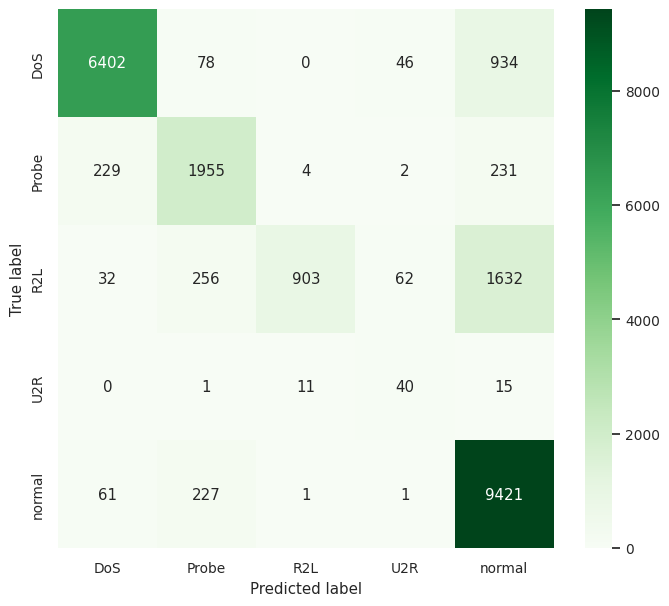

In [180]:
#绘制混淆矩阵
sns.set(font_scale=0.9)
cm = confusion_matrix(y_test_M, y_pred_M)
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [181]:
right = []
wrong = []
for i in range(len(classes)):
    right.append(len(y_pred_M[(y_test_M==classes[i])&(y_pred_M==classes[i])]))
    wrong.append(len(y_pred_M[(y_test_M==classes[i])&(y_pred_M!=classes[i])]))
num_df = pd.DataFrame({'classes':classes,'right':right,'wrong':wrong})
num_df.sort_values(by='right',ascending=False,inplace=True)
num_df.reset_index(drop=True,inplace=True)

/home/nucleon/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


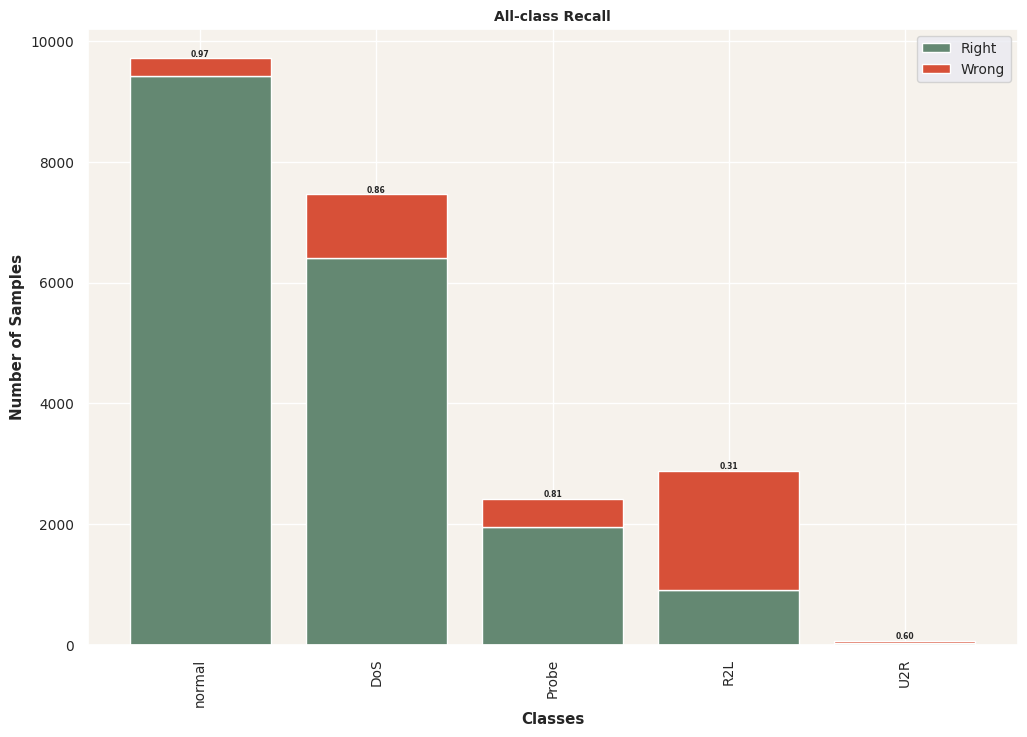

In [182]:
# 获取数据
classes = num_df['classes']
right = num_df['right']
wrong = num_df['wrong']
total = right + wrong
accuracy = right / total

# 绘制堆积条形图
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(classes, right, label='Right', color='#648872')
ax.bar(classes, wrong, bottom=right, label='Wrong', color='#D75038')

# 在每个柱子顶端添加文本标签
for i, v in enumerate(accuracy):
    ax.text(i, right[i] + wrong[i], f'{v:.2f}', ha='center', va='bottom', fontweight='bold',fontsize=5.5)

# 设置图表标题和标签
ax.set_title('All-class Recall',fontweight='bold',fontsize=10)
ax.set_xlabel('Classes',fontweight='bold')
ax.set_ylabel('Number of Samples',fontweight='bold')
ax.legend()

# 设置x轴标签属性
ax.set_xticklabels(classes, rotation=90)
# 设置图表背景色
ax.set_facecolor('#F6F2EC')

plt.show()